<a href="https://colab.research.google.com/github/KSKishore2005/codsoft-MACHNE-LEARNING-/blob/main/sms.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import string

In [2]:
# Machine Learning Libraries
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, accuracy_score
from imblearn.over_sampling import SMOTE
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from wordcloud import WordCloud
import nltk

In [3]:
# Suppress warnings for cleaner output
import warnings
warnings.filterwarnings('ignore')

In [4]:
# Download NLTK resources
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


True

In [5]:
# 1. Load the dataset
data = pd.read_csv('/content/spam.csv', encoding='latin-1')
data = data[['v1', 'v2']]
data.columns = ['label', 'message']

In [6]:
# 2. Data Preprocessing
print("Initial Data Shape:", data.shape)
print("Missing Values:\n", data.isnull().sum())
print("Class Distribution:\n", data['label'].value_counts())

Initial Data Shape: (5572, 2)
Missing Values:
 label      0
message    0
dtype: int64
Class Distribution:
 label
ham     4825
spam     747
Name: count, dtype: int64


In [7]:
# Remove missing values if any
data = data.dropna()

In [8]:

# Text Cleaning
stop = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

In [9]:
def clean_text(text):
    # Lowercase
    text = text.lower()
    # Remove punctuation
    text = text.translate(str.maketrans('', '', string.punctuation))
    # Remove numbers
    text = re.sub(r'\d+', '', text)
    # Remove whitespace
    text = text.strip()
    # Remove stopwords and lemmatize
    words = text.split()
    words = [lemmatizer.lemmatize(word) for word in words if word not in stop]
    return ' '.join(words)

data['cleaned_message'] = data['message'].apply(clean_text)


In [10]:
# Encode Labels
le = LabelEncoder()
data['label_num'] = le.fit_transform(data['label'])  # ham=0, spam=1


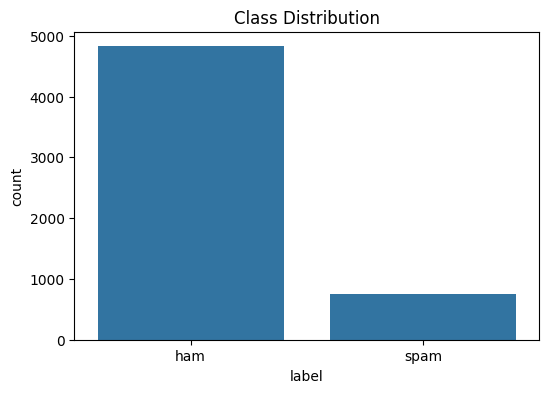

In [11]:
# 3. Exploratory Data Analysis
plt.figure(figsize=(6,4))
sns.countplot(x='label', data=data)
plt.title('Class Distribution')
plt.show()

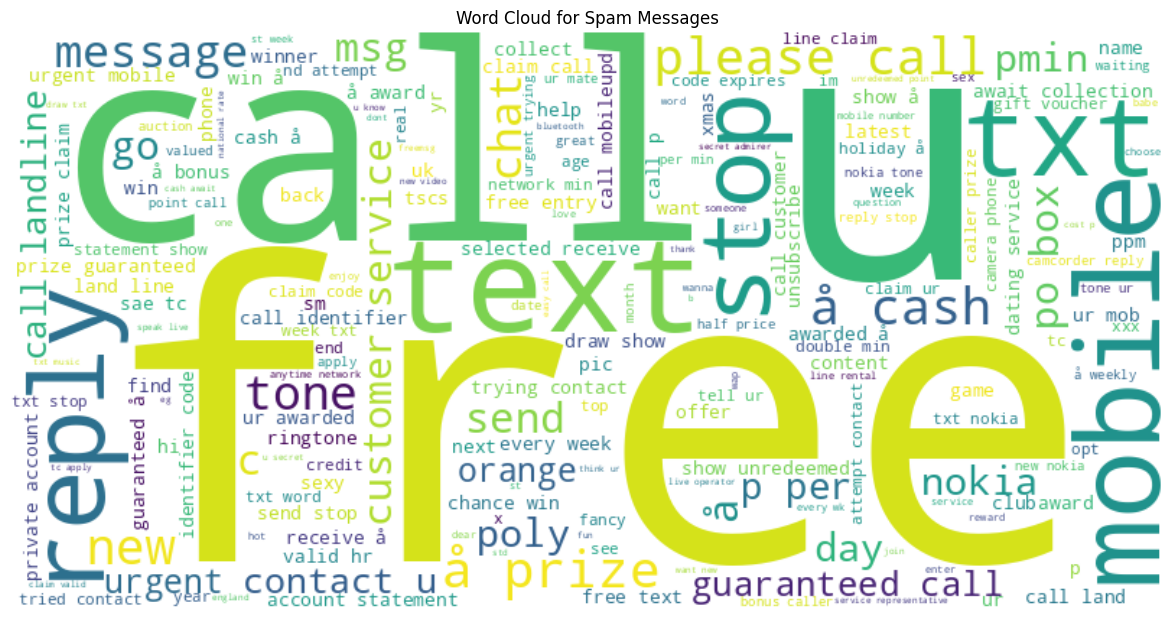

In [14]:

# Word Cloud for Spam
spam_words = ' '.join(data[data['label'] == 'spam']['cleaned_message'])
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(spam_words)

plt.figure(figsize=(15,7.5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud for Spam Messages')
plt.show()

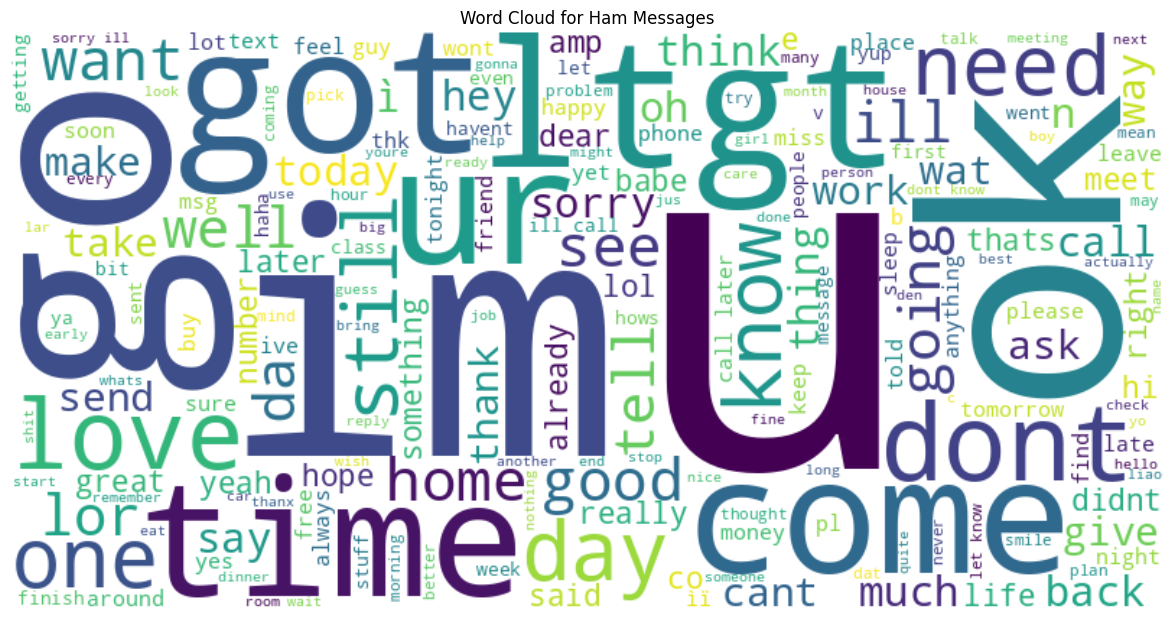

In [15]:
# Word Cloud for Ham
ham_words = ' '.join(data[data['label'] == 'ham']['cleaned_message'])
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(ham_words)

plt.figure(figsize=(15,7.5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud for Ham Messages')
plt.show()

In [16]:
# 4. Feature Extraction
tfidf = TfidfVectorizer(max_features=3000)
X_tfidf = tfidf.fit_transform(data['cleaned_message']).toarray()
y = data['label_num']

In [17]:
# 5. Handling Class Imbalance with SMOTE
print("Original Class Distribution:\n", pd.Series(y).value_counts())

sm = SMOTE(random_state=42)
X_res, y_res = sm.fit_resample(X_tfidf, y)

print("Resampled Class Distribution:\n", pd.Series(y_res).value_counts())


Original Class Distribution:
 label_num
0    4825
1     747
Name: count, dtype: int64
Resampled Class Distribution:
 label_num
0    4825
1    4825
Name: count, dtype: int64


In [18]:
# 6. Split the Data
X_train, X_test, y_train, y_test = train_test_split(
    X_res, y_res, test_size=0.2, random_state=42, stratify=y_res
)

In [19]:
# 7. Model Training

# Multinomial Naive Bayes
nb = MultinomialNB()
nb.fit(X_train, y_train)

# Logistic Regression
lr = LogisticRegression(max_iter=1000, class_weight='balanced')
lr.fit(X_train, y_train)

# Support Vector Machine
svm = SVC(kernel='linear', probability=True, class_weight='balanced', random_state=42)
svm.fit(X_train, y_train)

# 8. Model Evaluation
def evaluate_model(model, X_test, y_test, model_name="Model"):
    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)[:,1]

    print(f"--- {model_name} ---")
    print("Confusion Matrix:")
    print(confusion_matrix(y_test, y_pred))

    print("\nClassification Report:")
    print(classification_report(y_test, y_pred))

    print("Accuracy:", accuracy_score(y_test, y_pred))
    print("ROC-AUC Score:", roc_auc_score(y_test, y_proba))
    print("\n")

# Evaluate all models
evaluate_model(nb, X_test, y_test, "Multinomial Naive Bayes")
evaluate_model(lr, X_test, y_test, "Logistic Regression")
evaluate_model(svm, X_test, y_test, "Support Vector Machine")

--- Multinomial Naive Bayes ---
Confusion Matrix:
[[938  27]
 [ 34 931]]

Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.97      0.97       965
           1       0.97      0.96      0.97       965

    accuracy                           0.97      1930
   macro avg       0.97      0.97      0.97      1930
weighted avg       0.97      0.97      0.97      1930

Accuracy: 0.9683937823834197
ROC-AUC Score: 0.9934902950414776


--- Logistic Regression ---
Confusion Matrix:
[[942  23]
 [ 76 889]]

Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.98      0.95       965
           1       0.97      0.92      0.95       965

    accuracy                           0.95      1930
   macro avg       0.95      0.95      0.95      1930
weighted avg       0.95      0.95      0.95      1930

Accuracy: 0.9487046632124352
ROC-AUC Score: 0.9931638433246531


--- Support Vector Machine